# データ作成

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import random
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 画素の位置を適当に入れ替える
# SHUFFLED_INDICES = list(range(14*14))
# random.shuffle(SHUFFLED_INDICES)
# map_dict = {new_id: orig_id for new_id, orig_id in enumerate(SHUFFLED_INDICES)} # どのように入れ替わったかを示す dict {to: from}

# class RandomShuffle(object):
#     def __call__(self, tensor):
#         reshaped_tensor = tensor.view(-1)  # 1次元テンソルに変換
        
#         # シャッフルされたインデックスを使用してピクセルの順序を入れ替える
#         shuffled_tensor = reshaped_tensor[SHUFFLED_INDICES]
        
#         # シャッフル後のテンソルを元の形状に変形して返す
#         return shuffled_tensor.view(tensor.size())
        
# # データの前処理
# transform = transforms.Compose([
#     transforms.Resize((14, 14)),
#     transforms.ToTensor(),
#     RandomShuffle(),
# ])

# # MNISTデータセットの読み込み
# original_train_dataset = MNIST(root="./data", train=True, transform=transform, download=True)
# original_test_dataset = MNIST(root="./data", train=False, transform=transform, download=True)


In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

# CIFAR-10データセットのクラス名とインデックスの対応
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
selected_classes = ['airplane', 'automobile', 'bird', 'cat']
class_indices = { c: i for i, c in enumerate(cifar10_classes)}
selected_class_indices = [cifar10_classes.index(cls) for cls in selected_classes]

# CIFAR-10データセットの読み込み
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor(),
])
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

dataset_by_class = { c: [] for c in selected_classes}
for image, label in cifar10_dataset:
    class_name = cifar10_classes[label]
    if class_name in selected_classes:
        # print(f"image: {image.shape}")
        dataset_by_class[class_name].append(image)

for k in dataset_by_class:
    print(f"class {k}: {len(dataset_by_class[k])}")

# 新しいデータセットの作成
new_dataset = []
for i in range(5000):
    tensors = []
    for k in dataset_by_class:
        tensors.append(dataset_by_class[k][i])

    # 4つのTensorを2行2列に配置して結合する
    top_row = torch.cat([tensors[0], tensors[1]], dim=2)
    bottom_row = torch.cat([tensors[2], tensors[3]], dim=2)
    result_tensor = torch.cat([top_row, bottom_row], dim=1) # torch.Size([3, 32, 32])

    new_dataset.append(result_tensor)

    # print(f"concat tensor: {result_tensor.shape}")


Files already downloaded and verified
class airplane: 5000
class automobile: 5000
class bird: 5000
class cat: 5000


In [13]:
SHUFFLED_INDICES = list(range(32*32))
random.shuffle(SHUFFLED_INDICES)
map_dict = {new_id: orig_id for new_id, orig_id in enumerate(SHUFFLED_INDICES)} # どのように入れ替わったかを示す dict {to: from}

def shuffle_image_tensor(tensor):
    reshaped_tensor = tensor.view(3, -1)  # 1次元テンソルに変換
    
    # シャッフルされたインデックスを使用してピクセルの順序を入れ替える
    shuffled_tensor = reshaped_tensor[:, SHUFFLED_INDICES]
    
    # シャッフル後のテンソルを元の形状に変形して返す
    return shuffled_tensor.view(tensor.size())

shuffled_dataset = [shuffle_image_tensor(tensor) for tensor in new_dataset]

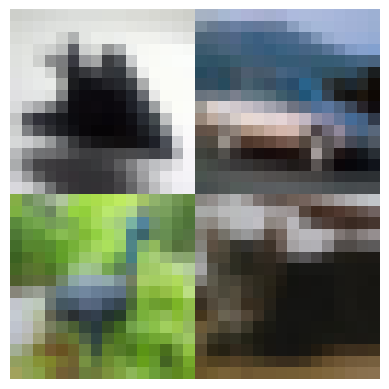

In [16]:
import matplotlib.pyplot as plt
image = new_dataset[0]
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

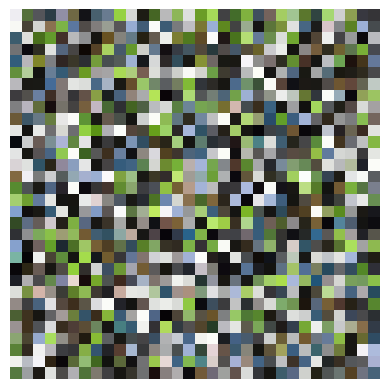

In [15]:
import matplotlib.pyplot as plt
image = shuffled_dataset[0]
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [47]:
shuffled_dataset = shuffled_dataset[:100]

In [48]:
len(shuffled_dataset)

100

## ベクトル作成

In [49]:
def timeseries_to_elementwise_vectors(dataset):
    tensors = [torch.flatten(d[0]) for d in dataset]
    mat = torch.stack(tensors, dim=1)
    
    # 次元ごとに取り出す
    dimwise_tensors = torch.unbind(mat)
    
    # リストに格納する
    dimwise_tensor_list = list(dimwise_tensors)

    # numpy に変換
    dimwise_tensors_np = [ t.numpy() for t in dimwise_tensor_list]

    return np.array(dimwise_tensors_np)


In [50]:
train_vectors = timeseries_to_elementwise_vectors(shuffled_dataset)
train_vectors.shape

(1024, 100)

## 可視化

In [51]:
# def id_to_dist_from_center(id: int, side_length=14) -> float:
#     """画素のidをもとに中心からの距離を計算する"""
#     col = id % side_length
#     row = id // side_length

#     center = (side_length - 1) / 2

#     return ((col-center)**2 + (row-center)**2)**0.5

def id_to_color(id: int, side_length=14) -> float:
    """画素のidをもとに中心からの距離を計算する"""
    
    col = id % side_length
    row = id // side_length

    if row < side_length // 2 and col < side_length // 2:
        # 左上
        color = 0
        
    elif row < side_length // 2:
        # 右上
        color = 1

    elif col < side_length // 2:
        # 左下
        color = 2

    else:
        color = 3
    
    center = (side_length - 1) / 2

    return color

<Axes: xlabel='x', ylabel='y'>

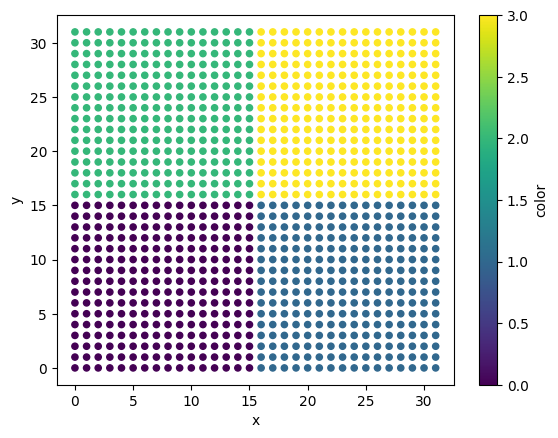

In [52]:
side_length = 32
df = pd.DataFrame(
    data = {
        "x": [i for i in range(side_length)] * side_length,
        "y": [i for i in range(side_length) for _ in range(side_length)],
        "color": [id_to_color(i, side_length=side_length) for i in range(side_length*side_length)]
    }
)
df.plot.scatter(x='x', y='y', c="color", colormap='viridis')

In [53]:
def vis(dataset):
    vectors = timeseries_to_elementwise_vectors(dataset)
    tsne = TSNE(n_components=2, random_state=0, perplexity=25.0)
    embeddings_2d = tsne.fit_transform(vectors)

    # 中心からの距離に基づき可視化
    df = pd.DataFrame(
        data={
            "x": embeddings_2d[:, 0],
            "y": embeddings_2d[:, 1],
            "color": [id_to_color(map_dict[id], side_length=32) for id in range(embeddings_2d.shape[0])]
        }
    )
    df.plot.scatter(x='x', y='y', c="color", colormap='viridis')


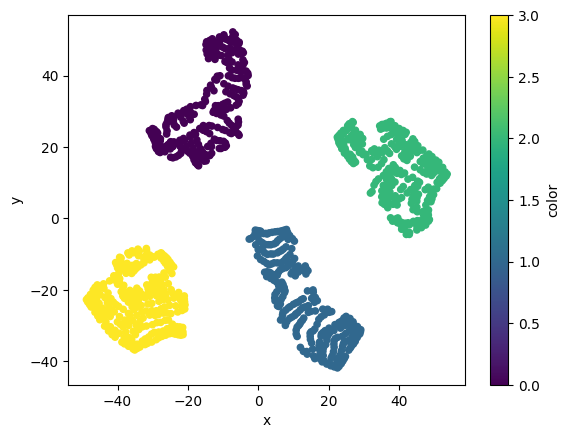

In [54]:
vis(shuffled_dataset)